In [10]:
library(DescTools) #Fisher Z
library(tidyverse)
library(rstatix) #ANOVA
library(reshape)#melt
library(ggpubr) #compare means
library(ggplot2)
library(plotly)

# Import data

In [19]:
dimension_model_loocv = read.csv('../output_data/model_comparison/LOOCV/dimension_model_loocv.csv',row.names=1)
colnames(dimension_model_loocv) = c('dimension_exp','dimension_imp','dimension_dim')

clustering_loocv = read.csv('../output_data/model_comparison/LOOCV/clustering_model_loocv_imp_revise.csv',row.names=1)
clustering_model_loocv = clustering_loocv[,c('exp','imp','imp_5c','imp_6c','dim_umap')]
colnames(clustering_model_loocv) = c('clustering_exp','clustering_imp','clustering_imp_5c',
                                     'clustering_imp_6c','clustering_dim_umap')

Hybrid_model_loocv = clustering_loocv['dim_pca_3k']
colnames(Hybrid_model_loocv) = c('hybrid_3k')

compare_loocv = cbind(clustering_model_loocv,Hybrid_model_loocv,dimension_model_loocv)
write.csv(compare_loocv, file = '../output_data/model_comparison/compare_loocv_imp_revise.csv')
head(compare_loocv) 

# For the implicit task, we ultimately chose a model with six categories.
compare_loocv = compare_loocv[,!colnames(compare_loocv)%in%c('clustering_imp','clustering_imp_5c')]
colnames(compare_loocv)[2] = 'clustering_imp'
compare_loocv

,clustering_exp,clustering_imp,clustering_imp_5c,clustering_imp_6c,clustering_dim_umap,hybrid_3k,dimension_exp,dimension_imp,dimension_dim
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2829071,0.2982362,0.3536933,0.2640628,0.6455163,0.6772955,0.4794173,0.4461545,0.6553121
1,0.3731233,0.1704496,0.1741873,0.1285962,0.5127164,0.6687937,0.3214935,0.4835032,0.7291011
2,0.4291904,0.3964899,0.4505674,0.3668629,0.6858408,0.8109155,0.5519851,0.5756909,0.6870715
3,0.3408413,0.3147878,0.2951668,0.2478418,0.6224655,0.6832862,0.1970913,0.1872180,0.5797626
4,0.2120660,0.2289928,0.3385327,0.3123585,0.6098234,0.7744044,0.3282318,0.3929765,0.6721745
5,0.3435366,0.1359798,0.3564274,0.3223454,0.5155182,0.6456927,0.1609300,0.4044867,0.5468313


,clustering_exp,clustering_imp,clustering_dim_umap,hybrid_3k,dimension_exp,dimension_imp,dimension_dim
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2829071,0.2640628,0.6455163,0.6772955,0.4794173,0.4461545,0.6553121
1,0.3731233,0.1285962,0.5127164,0.6687937,0.3214935,0.4835032,0.7291011
2,0.4291904,0.3668629,0.6858408,0.8109155,0.5519851,0.5756909,0.6870715
3,0.3408413,0.2478418,0.6224655,0.6832862,0.1970913,0.1872180,0.5797626
4,0.2120660,0.3123585,0.6098234,0.7744044,0.3282318,0.3929765,0.6721745
5,0.3435366,0.3223454,0.5155182,0.6456927,0.1609300,0.4044867,0.5468313
6,0.4410059,0.1724428,0.6467020,0.7126736,0.3864977,0.2697598,0.6924772
7,0.3285169,0.1919476,0.6360914,0.4120815,0.3989364,0.1728312,0.7032823
8,0.4289045,0.3565326,0.6092034,0.8102662,0.3639637,0.6036181,0.7036797


# ANOVA

In [21]:
compare_loocv_plot = compare_loocv
models = colnames(compare_loocv_plot) 
models_com = combn(models,2)
my_comparisons = list()
for (i in seq(1,ncol(models_com))){
    my_comparisons[[i]] = c(models_com[1,i], models_com[2,i])
}

compare_loocv_plot$'sub' = rownames(compare_loocv_plot)
compare_loocv_melt_plot = melt(compare_loocv_plot,id.vars='sub')
colnames(compare_loocv_melt_plot) = c('sub','model','r_value')

compare_loocv_melt_plot$model = factor(compare_loocv_melt_plot$model, 
                           levels = c('clustering_imp',
                                      'clustering_exp','clustering_dim_umap',
                                      'dimension_imp','dimension_exp','dimension_dim','hybrid_3k'))

compare_loocv_zscore_plot = FisherZ(compare_loocv_plot[1:7])#FisherZ
compare_loocv_zscore_plot$'sub' = rownames(compare_loocv_zscore_plot)
compare_loocv_zscore_melt_plot = melt(compare_loocv_zscore_plot,id.vars='sub')
colnames(compare_loocv_zscore_melt_plot) = c('sub','model','z_value')
compare_loocv_melt_plot$'z_value'=compare_loocv_zscore_melt_plot$'z_value'

res.aov = anova_test(
    data = compare_loocv_melt_plot,dv = z_value, wid = sub,
    within = model)
get_anova_table(res.aov)

# pairwise comparisons
pwc <- compare_loocv_melt_plot %>%
  pairwise_t_test(
    z_value ~ model, paired = TRUE,
    p.adjust.method = "bonferroni"
    )
pwc

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,model,6,78,43.187,7.94e-23,*,0.713


,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,z_value,clustering_imp,clustering_exp,14,14,-2.5077317,13,2.60e-02,5.50e-01,ns
2,z_value,clustering_imp,clustering_dim_umap,14,14,-14.2600497,13,2.57e-09,5.40e-08,****
3,z_value,clustering_imp,dimension_imp,14,14,-4.1875879,13,1.00e-03,2.20e-02,*
4,z_value,clustering_imp,dimension_exp,14,14,-1.1584444,13,2.68e-01,1.00e+00,ns
5,z_value,clustering_imp,dimension_dim,14,14,-13.6712110,13,4.31e-09,9.05e-08,****
6,z_value,clustering_imp,hybrid_3k,14,14,-7.8513176,13,2.74e-06,5.75e-05,****
7,z_value,clustering_exp,clustering_dim_umap,14,14,-11.8060306,13,2.54e-08,5.33e-07,****
8,z_value,clustering_exp,dimension_imp,14,14,-1.8428935,13,8.80e-02,1.00e+00,ns
9,z_value,clustering_exp,dimension_exp,14,14,0.5525925,13,5.90e-01,1.00e+00,ns


# Plot results

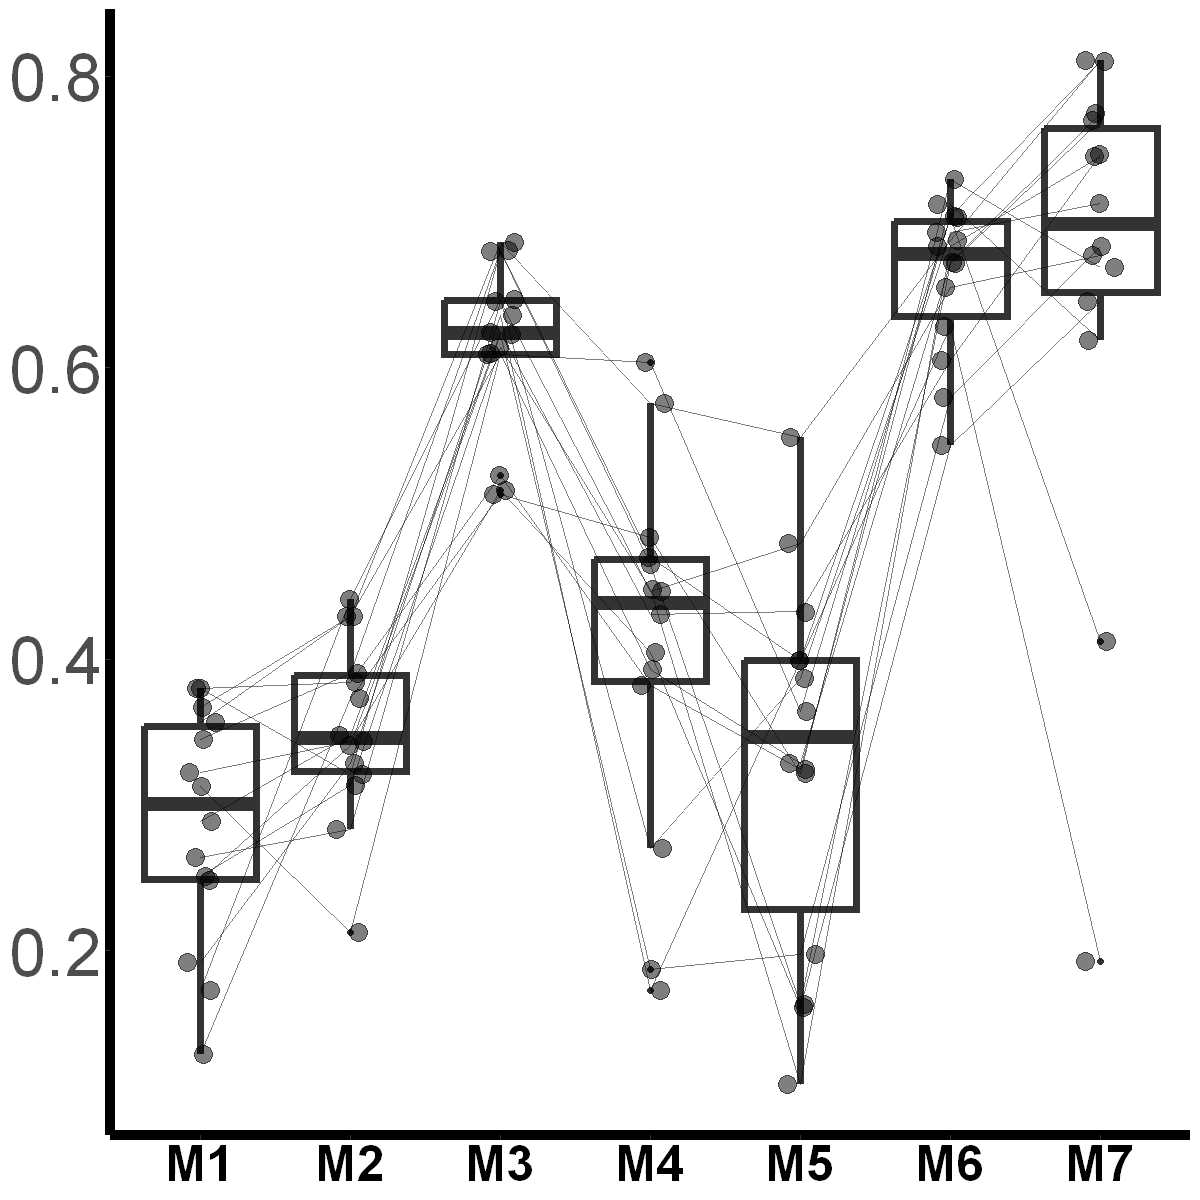

In [27]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(compare_loocv_melt_plot,aes(x=model,y=r_value))+
geom_boxplot(lwd=2)+
#stat_summary(fun = mean, geom = "point", shape = 16, size=8,color='red')+
geom_jitter(color="black", size=5,alpha=0.5,
            position = position_jitter(0.1))+
geom_line(aes(group = sub),alpha=0.5,size=0.5) + 
scale_x_discrete(labels = c("clustering_imp" = "M1",
                            "clustering_exp" = "M2",
                           "clustering_dim_umap" = "M3", 
                            "dimension_imp" = "M4", "dimension_exp" = "M5",
                           "dimension_dim" = "M6","hybrid_3k" = "M7")) + 

# ggtitle('Compare model LOOCV')+
theme_classic()+
theme(#axis.title.x = element_text(size=40,face='bold'),
      #axis.title.y = element_text(size=50,face='bold'),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.y = element_text(size=40),
      axis.text.x = element_text(size=30,face='bold',color="black"),
      #axis.text.x = element_blank(),
      axis.line.x=element_line(linetype=1,color="black",size=3),
      axis.line.y=element_line(linetype=1,color="black",size=3),      
      legend.key.size = unit(1,"cm"),
      legend.title = element_text(size=16,face='bold'),
      legend.text = element_text(size=18),
      plot.title = element_text(hjust = 0.5,size=18))+
ylab('LOOCV')+
xlab('')

In [29]:
png("../output_graph/ModelComparison_revise.png", bg="transparent",
    family = 'sans',units='in',width=10,height=10,res=300)
options(repr.plot.width=10, repr.plot.height=10)
ggplot(compare_loocv_melt_plot,aes(x=model,y=r_value))+
geom_boxplot(lwd=2)+
#stat_summary(fun = mean, geom = "point", shape = 16, size=8,color='red')+
geom_jitter(color="black", size=5,alpha=0.5,
            position = position_jitter(0.1))+
geom_line(aes(group = sub),alpha=0.5,size=0.5) + 
scale_x_discrete(labels = c("clustering_imp" = "M1","clustering_exp" = "M2",
                           "clustering_dim_umap" = "M3", 
                            "dimension_imp" = "M4", "dimension_exp" = "M5",
                           "dimension_dim" = "M6","hybrid_3k" = "M7")) + 

# ggtitle('Compare model LOOCV')+
theme_classic()+
theme(#axis.title.x = element_text(size=40,face='bold'),
      #axis.title.y = element_text(size=50,face='bold'),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.y = element_text(size=40),
      #axis.text.x = element_text(size=50,face='bold',color="black"),
      axis.text.x = element_blank(),
      axis.line.x=element_line(linetype=1,color="black",size=3),
      axis.line.y=element_line(linetype=1,color="black",size=3),      
      legend.key.size = unit(1,"cm"),
      legend.title = element_text(size=16,face='bold'),
      legend.text = element_text(size=18),
      plot.title = element_text(hjust = 0.5,size=18))+
ylab('LOOCV')+
xlab('')
dev.off()

png 
  2